In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
# Load your Train
Train = pd.read_csv('Task 1/train.csv')
Val = pd.read_csv('Task 1/val.csv')
Test = pd.read_csv('Task 1/test.csv')


In [3]:
# Preprocess the text
Train['cleaned_text'] = Train['abstract_text'].str.lower()
Val['cleaned_text'] = Val['abstract_text'].str.lower()
Test['cleaned_text'] = Test['abstract_text'].str.lower()

# Tokenization and Padding Parameters
vocab_size = 60000
max_length = 64
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(Train['cleaned_text'])

# Convert to sequences and pad for training data
train_sequences = tokenizer.texts_to_sequences(Train['cleaned_text'])
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
train_labels = pd.get_dummies(Train['target']).values

# Convert to sequences and pad for validation data
validation_sequences = tokenizer.texts_to_sequences(Val['cleaned_text'])
padded_validation_sequences = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_labels = pd.get_dummies(Val['target']).values

# Convert to sequences and pad for test data
test_sequences = tokenizer.texts_to_sequences(Test['cleaned_text'])
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_labels = pd.get_dummies(Test['target']).values

# Building the LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(Train['target'].unique()), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Training the LSTM Model
history = model.fit(padded_train_sequences, train_labels, epochs=20, validation_data=(padded_validation_sequences, validation_labels))

# Evaluate the model on validation data data
Validaiton_loss, Validation_accuracy = model.evaluate(padded_validation_sequences, validation_labels)
print(f"\nValidation Loss: {Validaiton_loss}, Validation Accuracy: {Validation_accuracy}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 128)           7680000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 7,787,397
Trainable params: 7,787,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2500/2500 [==============================] - 193s 74ms/step - loss: 0.6400 - accuracy: 0.7634 - val_l

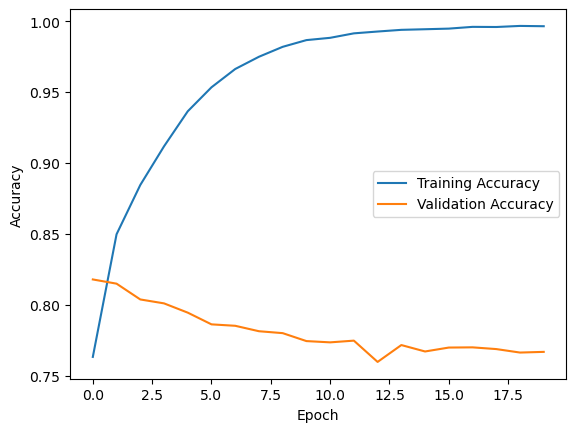

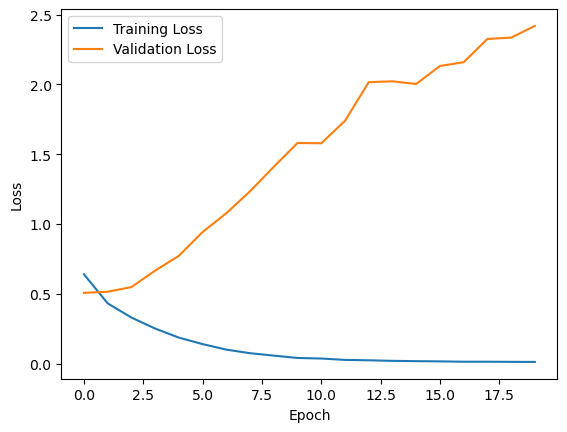

In [4]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
    

922/922 [==============================] - 56s 58ms/step - loss: 2.4651 - accuracy: 0.7697

Test Loss: 2.46506929397583, Test Accuracy: 0.7697080373764038


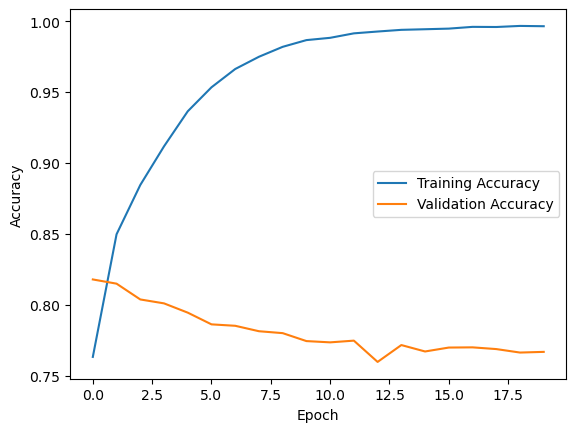

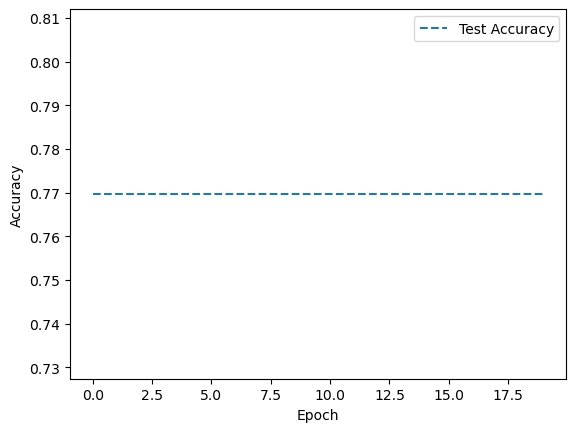

In [7]:

# Evaluate the model on test data data
Test_loss, Test_accuracy = model.evaluate(padded_test_sequences, test_labels)
print(f"\nTest Loss: {Test_loss}, Test Accuracy: {Test_accuracy}")

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting test accuracy separately
plt.plot([Test_accuracy] * len(history.history['accuracy']), label='Test Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

TASK 2

In [8]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,LSTM
from tensorflow.keras.utils import to_categorical

In [73]:



# Function to read sounds and convert to spectrograms
from numpy import reshape
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, Dropout


def read_data(folder_path):
    labels = []
    spectrograms = []

    for label in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, label)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                if file_path.endswith('.wav'):
                   # print(file_path)
                    y, sr = librosa.load(file_path)
                    S = librosa.stft(y)
                    S_mag = np.abs(S)
                    S_dB = librosa.amplitude_to_db(S_mag, ref=np.max)
                    spectrograms.append(S_dB)
                    labels.append(label)
    return spectrograms, labels

def read_data_lstm(folder_path, desired_size):
    labels = []
    spectrograms = []

    for label in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, label)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                if file_path.endswith('.wav'):
                    y, sr = librosa.load(file_path)
                    S = librosa.stft(y)
                    S_mag = np.abs(S)
                    S_dB = librosa.amplitude_to_db(S_mag, ref=np.max)
                    padded_spectrogram = pad2d(S_dB, desired_size)
                    spectrograms.append(padded_spectrogram)
                    labels.append(label)
    
    # Reshape for LSTM and Normalize
    spectrograms = np.array(spectrograms)
    spectrograms = spectrograms.reshape(len(spectrograms), desired_size, -1)  # Reshaping
    spectrograms -= np.mean(spectrograms, axis=0)  # Normalizing
    spectrograms /= np.std(spectrograms, axis=0)
    
    return spectrograms, labels

# Function to pad or trim a 2D array to a desired shape
def pad2d(a, desired_size):
    rows, cols = a.shape
    padded_a = np.zeros((desired_size, desired_size))
    rows_to_copy = min(rows, desired_size)
    cols_to_copy = min(cols, desired_size)
    padded_a[:rows_to_copy, :cols_to_copy] = a[:rows_to_copy, :cols_to_copy]
    return padded_a

# Create CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(num_classes, activation='softmax'))
    return model

from sklearn.preprocessing import LabelEncoder

def create_lstm_model(input_shape, num_classes):
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
    return model






In [67]:
# Path to dataset
folder_path = 'Task 2/Gun shot dataset/edge-collected-gunshot-audio'

# Read spectrograms and labels
spectrograms, labels = read_data(folder_path)

# Preprocess data
desired_spectrogram_size = 128
spectrograms = np.array([pad2d(s, desired_spectrogram_size) for s in spectrograms])
spectrograms = np.expand_dims(spectrograms, axis=-1)  # Add channel dimension
print(spectrograms.shape)
label_dict = {label: i for i, label in enumerate(set(labels))}
y = np.array([label_dict[label] for label in labels])
y = to_categorical(y)  # One-hot encoding

# Split data
X_train, X_test, y_train, y_test = train_test_split(spectrograms, y, test_size=0.2, random_state=42)

# Define input shape and number of classes
input_shape = X_train[0].shape
num_classes = y.shape[1]

(2148, 128, 128, 1)


In [71]:
# Create and compile the model
model = create_cnn_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

# Save the model
model.save('gunshot_classification_model_cnn.h5')

Epoch 1/100
54/54 [==============================] - 104s 1s/step - loss: 1.2262 - accuracy: 0.5588 - val_loss: 1.6024 - val_accuracy: 0.3233
Epoch 2/100
54/54 [==============================] - 17s 320ms/step - loss: 0.3929 - accuracy: 0.8708 - val_loss: 0.7087 - val_accuracy: 0.7442
Epoch 3/100
54/54 [==============================] - 15s 270ms/step - loss: 0.1457 - accuracy: 0.9610 - val_loss: 0.4502 - val_accuracy: 0.8535
Epoch 4/100
54/54 [==============================] - 17s 310ms/step - loss: 0.0711 - accuracy: 0.9831 - val_loss: 0.2981 - val_accuracy: 0.8860
Epoch 5/100
54/54 [==============================] - 15s 288ms/step - loss: 0.1129 - accuracy: 0.9662 - val_loss: 1.1635 - val_accuracy: 0.6628
Epoch 6/100
54/54 [==============================] - 20s 365ms/step - loss: 0.1734 - accuracy: 0.9517 - val_loss: 0.2993 - val_accuracy: 0.8977
Epoch 7/100
54/54 [==============================] - 17s 325ms/step - loss: 0.0741 - accuracy: 0.9825 - val_loss: 0.4288 - val_accuracy: 0

In [72]:
from keras.models import load_model
model = load_model('gunshot_classification_model_cnn.h5')
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')  # Choose 'macro' or 'micro' based on your need
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')       # Choose 'macro' or 'micro' based on your need
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')               # Choose 'macro' or 'micro' based on your need

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9
Precision: 0.901811601464823
Recall: 0.9
F1 Score: 0.899545213613403


In [76]:
spectrograms, labels = read_data_lstm(folder_path, desired_spectrogram_size)

# Encode Labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Split data into training and testing (you can use train_test_split from sklearn)

# Define input shape and number of classes
input_shape = (desired_spectrogram_size, desired_spectrogram_size)  # Change according to your data reshaping
num_classes = len(np.unique(labels))

# Create LSTM model
model = create_lstm_model(input_shape, num_classes)

# Compile and train the model as needed
X_train, X_test, y_train, y_test = train_test_split(spectrograms, categorical_labels, test_size=0.2, random_state=42)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

# Save the model
model.save('gunshot_classification_model_lstm.h5')

Epoch 1/100
54/54 [==============================] - 14s 116ms/step - loss: 1.2986 - accuracy: 0.3888 - val_loss: 1.1506 - val_accuracy: 0.4442
Epoch 2/100
54/54 [==============================] - 2s 40ms/step - loss: 1.1239 - accuracy: 0.4965 - val_loss: 0.9942 - val_accuracy: 0.5767
Epoch 3/100
54/54 [==============================] - 2s 37ms/step - loss: 1.0000 - accuracy: 0.5681 - val_loss: 0.9772 - val_accuracy: 0.5698
Epoch 4/100
54/54 [==============================] - 3s 51ms/step - loss: 0.9014 - accuracy: 0.6123 - val_loss: 0.9730 - val_accuracy: 0.6070
Epoch 5/100
54/54 [==============================] - 2s 40ms/step - loss: 0.8418 - accuracy: 0.6583 - val_loss: 0.7901 - val_accuracy: 0.6535
Epoch 6/100
54/54 [==============================] - 2s 37ms/step - loss: 0.7367 - accuracy: 0.7014 - val_loss: 0.8377 - val_accuracy: 0.6628
Epoch 7/100
54/54 [==============================] - 2s 38ms/step - loss: 0.6756 - accuracy: 0.7270 - val_loss: 0.6746 - val_accuracy: 0.7116
Epoc

In [75]:
model = load_model('gunshot_classification_model_lstm.h5')
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')  # Choose 'macro' or 'micro' based on your need
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')       # Choose 'macro' or 'micro' based on your need
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')               # Choose 'macro' or 'micro' based on your need

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7744186046511627
Precision: 0.7820562806606457
Recall: 0.7744186046511627
F1 Score: 0.7742273423156197


REPORT

Accuracy:

CNN: 0.9 (90%)
LSTM: 0.7744 (77.44%)
The CNN model correctly predicts the outcome 90% of the time, which is significantly higher than the 77.44% accuracy of the LSTM model.

Precision:
CNN: 0.9018
LSTM: 0.7821
 The CNN model has a higher precision, indicating fewer false positives.

Recall:
CNN: 0.9
LSTM: 0.7744
Again, the CNN model shows a higher recall, indicating it misses fewer true positives.

F1 Score:
CNN: 0.8995
LSTM: 0.7742
 The CNN model has a higher F1 score, suggesting a better overall balance between precision and recall.

CNN Model
Performance: Your CNN model shows better performance in terms of accuracy, precision, recall, and F1 score.

Training Time: However, it takes significantly longer to train (29 minutes) compared to the LSTM model.


LSTM Model
Performance: The LSTM model has lower performance metrics across the board.

Training Time: It has the advantage of being faster to train, taking only 16 minutes and 30 seconds.

Failed implementaitions: A Potential  hybrid models combining CNN and LSTM layers was designed to evauate the metrics of a fast and effiecient model however it did not function correctly and was ommited from the final implementation and report. 

Discussion and Conclusion

CNN Model
Performance: The CNN model has shown superior performance in terms of accuracy, precision, recall, and F1 score. This suggests that it is more effective at capturing the relevant features in your audio data for classification purposes.

Training Time: The CNN model takes considerably longer to train (29 minutes). This could be due to the inherent complexity of the model, the number of parameters, and the computational intensity of convolutional operations.

Suitability: CNNs are generally very effective for tasks involving spatial feature recognition. When applied to audio data, especially spectrograms, they can effectively capture spectral and temporal patterns, which seems to be the case with your dataset.

LSTM Model
Performance: The LSTM model's performance is lower compared to the CNN. This might be due to LSTM's focus on capturing temporal or sequential dynamics, which might not be as critical in your dataset for the classification task at hand.

Training Time: It trains faster (16 minutes and 30 seconds), which could be a result of a simpler model architecture or fewer parameters to train compared to the CNN.

Suitability: LSTMs excel in learning from sequences, making them ideal for time-series data. However, in your case, the nature of the audio data might not fully leverage the sequential processing capabilities of LSTMs, or the specific features relevant for classification might be more spatial than temporal.

Conclusion
Model Selection: The choice between CNN and LSTM for audio classification tasks should consider the nature of the audio data and the specific requirements of the task. CNN's ability to capture spatial features in the spectrograms seems to be more beneficial for classification.
Trade-offs: There is a trade-off between performance and training efficiency. While the CNN offers better classification metrics, it demands longer training times. The LSTM, while not as accurate, is more efficient in terms of training time.




EXTRA CREDIT

Title: "Gun identification from gunshot audios for secure public places using transformer learning" by Rahul Nijhawan, Sharik Ali Ansari, Sunil Kumar, Fawaz Alassery, and Sayed M. El-kenawy.

Research Question: How can transformer learning be utilized for gun-type detection from gunshot audio?
Methodology: Employed Mel-frequency-based audio features and compared convolution-based and fully self-attention-based (transformers) architectures.
Key Findings: The transformer architecture showed a classification accuracy of 93.87%, suggesting its effectiveness in gun-type detection from audio clips of gunshots​​.
Title: "Measurements Analysis Classification and Detection of Gunshot and Gunshot-like Sounds" by Rajesh Baliram Singh and Hanqi Zhuang.

Research Question: How can machine learning strategies be used to distinguish between gunshot and gunshot-like sounds?
Methodology: Used feature importance analysis, feature reduction, and random forest classifiers.
Key Findings: Identified critical Mel-frequency cepstral coefficients features for distinguishing gunshot sounds from similar sounds, contributing to improved acoustic gunshot detection systems​​.
Title: "Alignment Based Matching Networks" (exact title unmentioned in the provided sections).

Research Question: How can image classification be improved in low-data settings?
Methodology: Developed a two-tier matching system, Alignment Based Matching Networks (ABM Nets), for image alignment and classification.
Key Findings: Demonstrated that the model operates effectively in low-data environments and can align images for object class determination without significantly impacting runtime​​.
Title: "A novel gunshot detector device for indoor environments" (exact title unmentioned in the provided sections).

Research Question: How can indoor gunshot sounds be detected and reported in real-time?
Methodology: Developed an electronic gunshot detector device using a convolutional neural network (CNN) trained on a large dataset of sounds.
Key Findings: The device achieved 98% accuracy in classifying gunshot sounds and was able to notify emergency responders and users via smartphone notifications, enhancing the speed and efficiency of emergency response​​.
Title: "Machine learning inspired efficient acoustic gunshot detection and localization system" by Muhammad Salman Kabir, Junaid Mir, Caleb Rascon, Muhammad Laiq Ur Rahman Shahid, and Furqan Shaukat.

Research Question: How can machine learning be used to improve real-time gunshot detection and localization?
Methodology: Utilized a variety of audio features and machine learning classifiers, including bagged tree ensemble and support vector machine, to detect and localize gunshots.
Key Findings: The system achieved a detection accuracy of 97.3%, highlighting its potential for efficient real-time gunshot detection and localization in security systems​​.